In [1]:
from scipy.io import netcdf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import xarray
import pandas as pd
import datetime
from datetime import datetime, timedelta
import geopandas as gpd
from itertools import groupby
import harmonica as hm

In [2]:
#Check memory: ps aux  | awk '{print $6/1024 " MB\t\t" $11}'  | sort -nr | head -1

In [3]:
wind_facilities = pd.read_csv('wind-facilities.csv')
data = xarray.open_dataset('/g/data/v46/lh2344/LLJ_2015_18.nc')
jetnight = xarray.open_dataset('/g/data/v46/lh2344/jetnights')
windlat = wind_facilities.Latitude
windlong = wind_facilities.Longitude

nj = 40
ni = 83
jstart = 241
jend = jstart + nj
istart = 690
iend = istart + ni
topog = xarray.open_dataset('Downloads/topog-an-slv-PT0H-BARRA_R-v1-20150207T0000Z.nc')
topog = topog.topog
topog = topog[jstart:jend,istart:iend]

In [4]:
def contourplot(profile, title):
    levels = np.arange(0,profile.max(),1)
    src = ccrs.PlateCarree()
    ax = plt.axes(projection=src)
    
    cmap=matplotlib.cm.get_cmap('RdPu')
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    lh = ax.gridlines(xlocs=range(131,171,1), ylocs=range(-39,-27,1),draw_labels=True)
    lh.top_labels = False
    lh.right_labels = False
    ch = ax.contourf(lon2d, lat2d, profile, levels, extend = 'both',cmap=cmap)
    top = ax.contour(lon2d, lat2d, topog, 40, color = 'black')
    ax.clabel(top, inline=1, fontsize=10)
    ax.coastlines('50m', linewidth=1)
    #ax.scatter(windlong, windlat, marker='x', color='blue', label = 'windfarms')
    ax.set_title(title)
    ax.set_ylim(lat2d.min(), lat2d.max())
    ax.set_xlim(lon2d.min(),lon2d.max())
    ax.scatter(143.3616, -36.4362, marker='x', color='blue', label = 'windfarms')
#     ax.set_ylim(-35, -38)
#     ax.set_xlim(142, 145)
    ax.legend(loc = [0,1])
    plt.text(1,9.2,'Coonooer Bridge', fontsize = 15)
    out=plt.colorbar(ch,cax=cax, **kw)
    out.set_label('Frequency',size=10)

In [5]:
# plt.figure(figsize = (12,12))
# contourplot(totaljets_variable, 'LLJ occurences in SE Australia 2015-18 with Topography Contours')
# plt.savefig('Contour graph with topography')

In [6]:
def contourplot_sliced(profile, title, latstart, latend, lonstart, lonend):
    levels = np.arange(0,profile.max(),1)
    plt.figure(figsize=(6, 6))
    src = ccrs.PlateCarree()
    ax = plt.axes(projection=src)
    ax.coastlines('50m', linewidth=1)
    cmap=matplotlib.cm.get_cmap('RdPu')
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    lh = ax.gridlines(xlocs=range(131,171,1), ylocs=range(-39,-27,1),draw_labels=True)
    lh.top_labels = False
    lh.right_labels = False
    lon = lon2d.isel(dim_0 = slice(latstart,latend), dim_1= slice(lonstart,lonend))
    lat = lat2d.isel(dim_0 = slice(latstart,latend), dim_1= slice(lonstart,lonend))
    ch = ax.contourf(lon, lat, profile, levels, extend = 'both',cmap=cmap)
    ax.set_title(title)
    out=plt.colorbar(ch,cax=cax, **kw)
    out.set_label('Frequency',size=10)

In [7]:
def gridpoints(latitude, longitude):
    lat = np.linspace(lat2d.min(), lat2d.max(), nj) #min, max lat
    lon = np.linspace(lon2d.min(),lon2d.max(),ni) #min, max lon
    abs_val_lat, abs_val_lon = np.abs(lat - latitude), np.abs(lon - longitude)
    lat_grid, lon_grid  =  abs_val_lat.argmin(), abs_val_lon.argmin()
    return lat_grid, lon_grid
    print('lat,lon', lat_grid,',', lon_grid)

In [8]:
dstart = datetime(2015,1,1,0,0,0)
ndays = 365*3 + 366
nj = 40
ni = 83
nt = ndays*24

jstart = 241
jend = jstart + nj
istart = 690
iend = istart + ni
pstart = 28
pend = 37
plevels = pend-pstart
heights_std = np.arange(100.0,1200.0,100.0)

In [9]:
# jetnight2 = jetnight.jetnight2
# ws100m_jn = jetnight.ws100m_jn
# ws100m_nonjn = jetnight.ws100m_nonjn
# jetnight_sum = jetnight2.sum(axis=0)
wsprof_interp = data.wsprof_interp

lon2d = data.lon2d
lat2d = data.lat2d


profmax_ind = data.profmax_ind
profmax = data.profmax
wsabove = data.wsabove
wsbelow = data.wsbelow

coords_isosurf={
    wsprof_interp.dims[0]:wsprof_interp.coords[wsprof_interp.dims[0]],   # time name and dimension
    wsprof_interp.dims[2]:wsprof_interp.coords[wsprof_interp.dims[2]],   # latitude name and dimension
    wsprof_interp.dims[3]:wsprof_interp.coords[wsprof_interp.dims[3]]    # longitude name and dimension
}

In [10]:
print(lat2d[19,22])
print(lon2d[19,22])

<xarray.DataArray 'lat2d' ()>
array(-36.4, dtype=float32)
<xarray.DataArray 'lon2d' ()>
array(143.32, dtype=float32)


In [11]:
profmax_ind = np.argmax(wsprof_interp[:,1:10,...].data, axis=1) + 1  # must add 1 if starting at index = 1

profmax_ind_above = profmax_ind + 1
profmax_ind_below = profmax_ind - 1      

profmax_ind_above = xarray.DataArray(profmax_ind_above, dims=("time","latitude","longitude"))  
profmax_ind_below = xarray.DataArray(profmax_ind_below, dims=("time","latitude","longitude"))
profmax_ind = xarray.DataArray(profmax_ind, dims=("time","latitude","longitude"), coords = coords_isosurf)

wsabove = wsprof_interp.isel(isosurf = profmax_ind_above) #windspeed above max evaluated on isosurf axis
profmax = wsprof_interp.isel(isosurf = profmax_ind)
wsbelow = wsprof_interp.isel(isosurf = profmax_ind_below) #windspeed below


In [12]:
# variable criteria algorithm

fixed_criteria = 2
variable_criteria = 0.2 # windspeed above and below is more than x% below the maxima
percent =  1 - variable_criteria 

speed_crit = profmax > 7
#falloff_crit = (profmax - min(wsprof_interp.isel(isosurf = (profmax_ind,10)))) > 5
below_crit = wsbelow <= 0.8 * profmax
above_crit = wsabove <= 0.8 * profmax

jetbinary_variable = (speed_crit & below_crit & above_crit) * 1

# fixed criteria algorithm
jetbinary_fixed = ((profmax - wsabove >= fixed_criteria) & (profmax - wsbelow >= fixed_criteria)) * 1

solartime = timedelta(hours=(144.96*12/180))
t = np.arange(dstart + solartime, dstart + timedelta(hours=nt)+solartime, timedelta(hours=1)).astype(datetime)
timeutc = np.arange(dstart, dstart + timedelta(hours=nt), timedelta(hours=1)).astype(datetime) # for leaving in UTC time

wsprof_interp['time'] = t
jetbinary_variable['time'] = t
jetbinary_fixed['time'] = t

In [13]:
# profiles = wsprof_interp.where(jetbinary_variable==1, drop = True)

In [14]:
# for t in range(0,2000):
#     plt.plot(profiles[t,:,19,22], heights_std)
#     plt.title('Random Jet Profiles at Maximum Jet Gridpoint')
#     plt.xlabel('Windspeed (m/s)')
#     plt.ylabel('Height AGL')
# plt.savefig('Jet_profiles')
    

In [15]:
# wsprof_interp[...,19,22].plot(y = 'isosurf') # for plotting individual profiles

In [16]:
# To filter so object only contains 0000UTC and 1200UTC (for comparing to sounding) 

# jbv_filtered = jetbinary_variable.isel(time = ((jetbinary_variable.time.dt.hour==0)|(jetbinary_variable.time.dt.hour==12)))
# jbf_filtered = jetbinary_fixed.isel(time = ((jetbinary_fixed.time.dt.hour==0)|(jetbinary_fixed.time.dt.hour==12)))


In [17]:
jetbinary_2015 = jetbinary_variable.isel(time = slice(0,8760))
jetbinary_2016 = jetbinary_variable.isel(time = slice(8761,17544))
jetbinary_2017 = jetbinary_variable.isel(time = slice(17545,26304))
jetbinary_2018 = jetbinary_variable.isel(time = slice(26305,35064))

totaljets_2015 = jetbinary_2015.sum(dim = 'time')
totaljets_2016 = jetbinary_2016.sum(dim = 'time')
totaljets_2017 = jetbinary_2017.sum(dim = 'time')
totaljets_2018 = jetbinary_2018.sum(dim = 'time')

totaljets_variable = jetbinary_variable.sum(dim = 'time')
totaljets_fixed = jetbinary_fixed.sum(dim = 'time')

# Summing jets for the filtered objects
# totaljets_jbvfiltered = jbv_filtered.sum(dim='time')
# totaljets_jbffiltered = jbf_filtered.sum(dim='time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


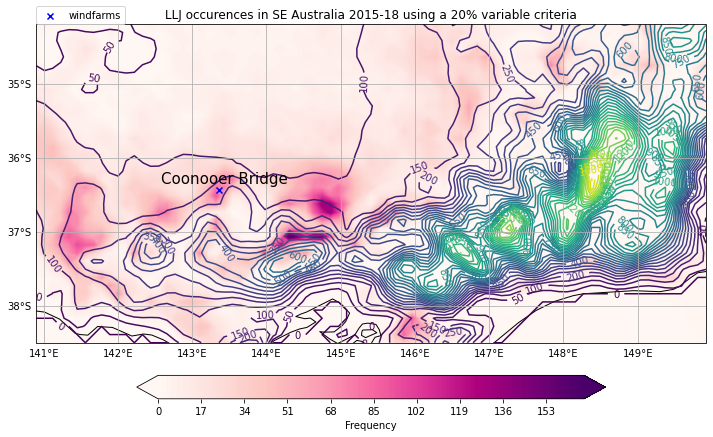

In [18]:
plt.figure(figsize = (12,12))
contourplot(totaljets_variable, 'LLJ occurences in SE Australia 2015-18 using a 20% variable criteria')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


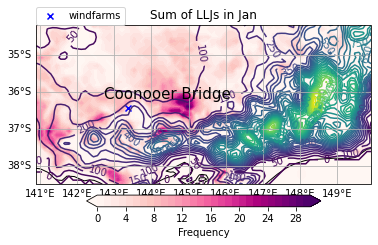

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


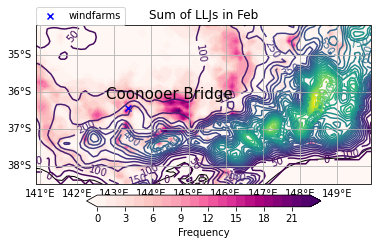

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


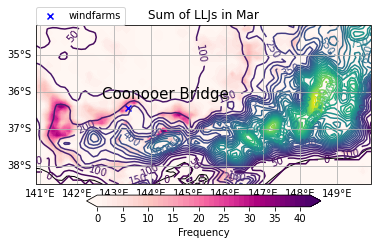

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


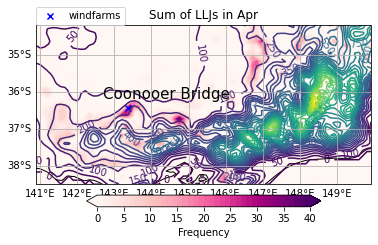

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


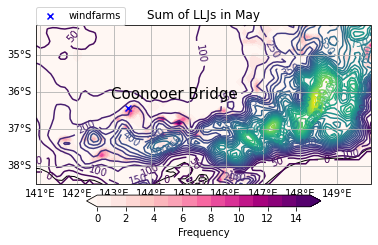

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


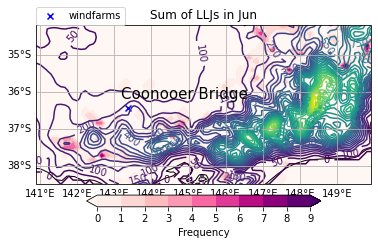

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


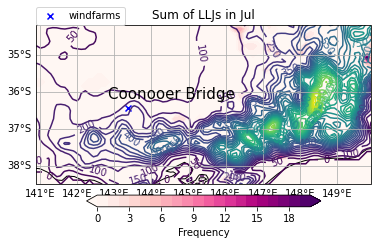

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


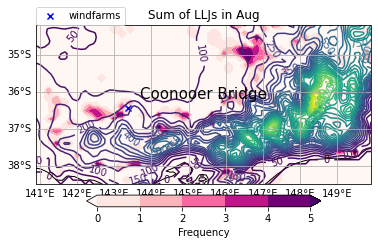

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


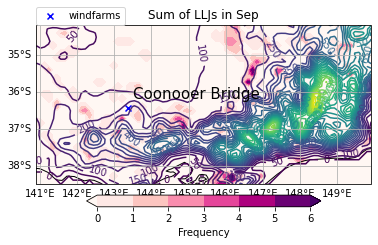

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


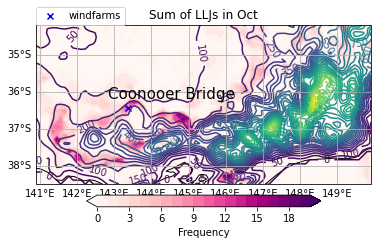

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


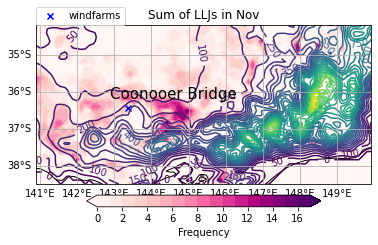

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


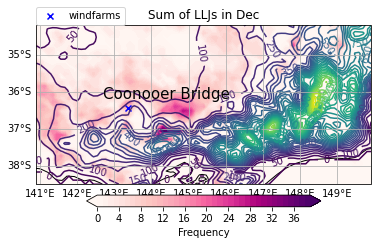

In [20]:
jetbinary_variable_bymonth = jetbinary_variable.groupby('time.month').sum()

month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i in np.arange(0,12):
    contourplot(jetbinary_variable_bymonth.isel(month=i), 'Sum of LLJs in ' + month[i])
    plt.show()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


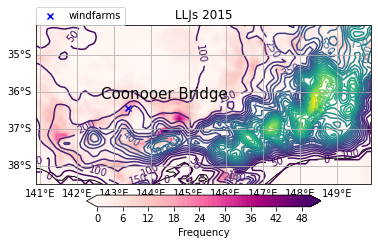

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


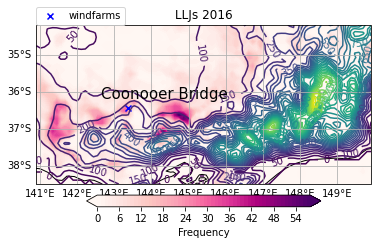

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


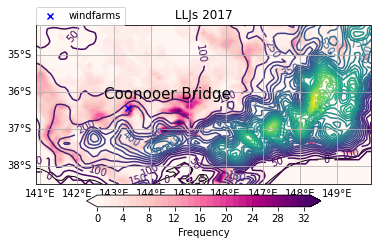

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


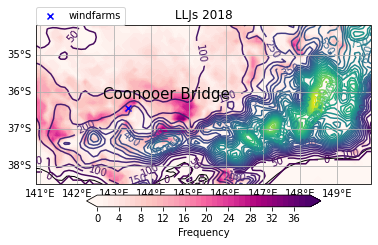

In [19]:
# v = totaljets_variable#.isel(time = slice(#.isel(latitude = slice(3,9), longitude= slice(24,30))
# f = totaljets_fixed#.isel(latitude = slice(3,9), longitude= slice(24,30))
annual_data = [totaljets_2015, totaljets_2016, totaljets_2017, totaljets_2018]
years = [2015, 2016, 2017, 2018]

for index, i in enumerate(annual_data):
    contourplot(i, 'LLJs ' + str(years[index]))
    plt.show()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


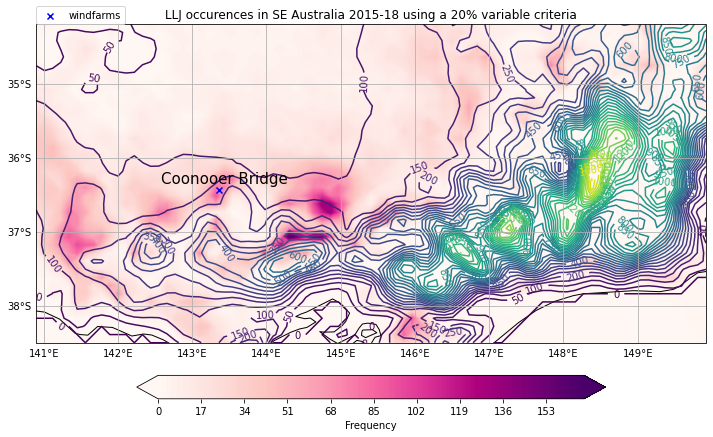

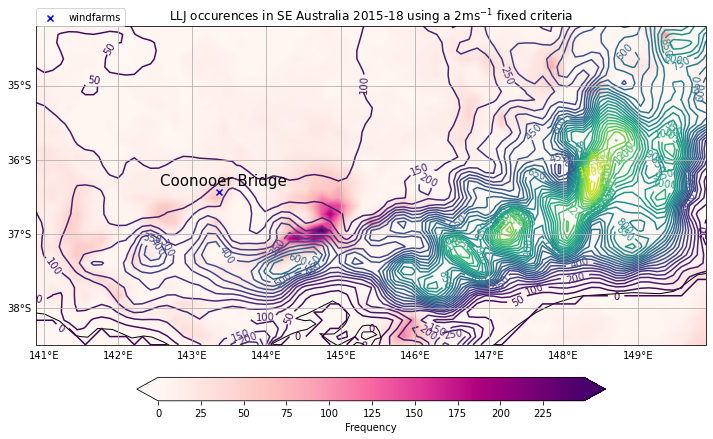

In [20]:
plt.figure(figsize = (12,12))
contourplot(totaljets_variable, 'LLJ occurences in SE Australia 2015-18 using a 20% variable criteria')
plt.plot()

plt.figure(figsize = (12,12))
contourplot(totaljets_fixed, 'LLJ occurences in SE Australia 2015-18 using a 2$\mathregular{ms^{-1}}$ fixed criteria')
plt.savefig('LLJs all years variable & fixed')

### Subregion analysis

ValueError: Filled contours require at least 2 levels.

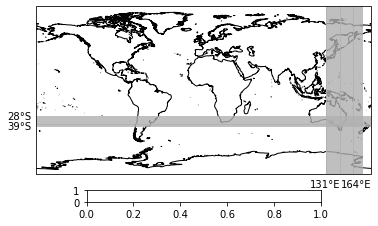

In [21]:
def contourplot_sliced(profile, title, latstart, latend, lonstart, lonend):
    levels = np.arange(0,profile.max(),1)
    plt.figure(figsize=(6, 6))
    src = ccrs.PlateCarree()
    ax = plt.axes(projection=src)
    ax.coastlines('50m', linewidth=1)
    cmap=matplotlib.cm.get_cmap('RdPu')
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    lh = ax.gridlines(xlocs=range(131,171,1), ylocs=range(-39,-27,1),draw_labels=True)
    lh.top_labels = False
    lh.right_labels = False
    lon = lon2d.isel(dim_0 = slice(latstart,latend), dim_1= slice(lonstart,lonend))
    lat = lat2d.isel(dim_0 = slice(latstart,latend), dim_1= slice(lonstart,lonend))
    ch = ax.contourf(lon, lat, profile, levels, extend = 'both',cmap=cmap)
    ax.set_title(title)
    out=plt.colorbar(ch,cax=cax, **kw)
    out.set_label('Frequency',size=10)
    
contourplot_sliced(totaljets_2018.isel(latitude = slice(6,8), longitude = slice(35,37)), 'Melb Airport all years', 6,8,35,37)
contourplot_sliced(totaljets_jbvfiltered.isel(latitude = slice(6,8), longitude = slice(35,37)), 'Melb Airport all years', 6,8,35,37)

In [ ]:
#filters so that only gridpoints of maximum frequency are displayed, all others are masked
filt = totaljets_variable.where(totaljets_variable==totaljets_variable.max(), drop=True)
jetbinary_variable = (speed_crit & below_crit & above_crit)
filt
#llj_profiles = wsprof_interp.where(jetbinary_variable)
#llj_profiles = data.llj_profiles

In [ ]:
# datefmt = dstart.strftime('%b, %Y')
# plt.figure(figsize=(6,6))
# for t in np.arange(0,1):
#     llj_profiles_filt = llj_profiles.isel(latitude = slice(19,20), longitude= slice(68,69))
#     llj_profiles_stack = llj_profiles_filt.stack(gridpoint = ("latitude", "longitude"))
#     plt.plot(llj_profiles_stack[t,...].reshape(11,2*2), heights_std)
#     plt.xlabel('Wind speed [m/s]')
#     plt.ylabel('Height AGL [m]')
#     plt.title('Ws Profiles Mt Kosciuszko')
#     plt.savefig('Kosciuszko all years')

# plt.show()

In [ ]:
def diurnal_hist(jetbinary_variable, title):
    solartime = timedelta(hours=(144.96*12/180)) #solar time adjustment for Melbourne longitude
    t = np.arange(dstart + solartime, dstart + timedelta(hours=nt)+solartime, timedelta(hours=1)).astype(datetime) 
    jetbinary_variable['time'] = t
    frequency = jetbinary_variable.groupby('time.hour').sum()
    hourly_frequency = np.empty(24)
    hours = np.arange(0,24)
    for t in hours:
        hourly_frequency[t] = (frequency[t,...].sum())/(jetbinary_variable.sum()) 
                                      
    plt.bar(hours,hourly_frequency)
    plt.ylabel('Probability') 
    plt.xlabel('Approximated Solar Time at 144.96\N{DEGREE SIGN}E')
    plt.title(title)
    plt.xticks(hours)
    return plt.savefig(title)

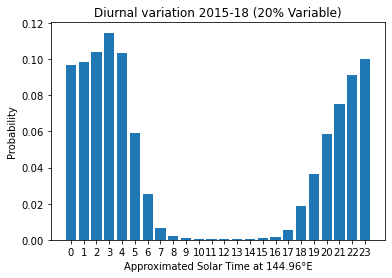

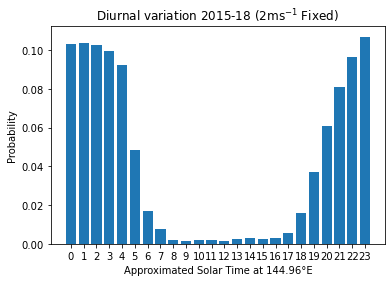

In [28]:
#diurnal_hist(jetbinary_variable.isel(latitude = slice(31,32), longitude = slice(80,81)), 'LLJ Frequency near Lake George')
diurnal_hist(jetbinary_variable, 'Diurnal variation 2015-18 (20% Variable)')
plt.show()
diurnal_hist(jetbinary_fixed, 'Diurnal variation 2015-18 (2$\mathregular{ms^{-1}}$ Fixed)')
plt.show()
# diurnal_hist(jetbinary_variable.isel(latitude = slice(3,9), longitude= slice(24,30)), 'Diurnal Variation Mt Mercer (20% Variable)')
# plt.show()
# diurnal_hist(jetbinary_fixed.isel(latitude = slice(3,9), longitude= slice(24,30)), 'Diurnal Variation Mt Mercer (2$\mathregular{ms^{-1}}$ Fixed)')
# plt.show()
# diurnal_hist(jetbinary_variable.isel(latitude = slice(13,15), longitude= slice(28,37)), 'That max area (-37S,144-145E) (2$\mathregular{ms^{-1}}$ Variable)')
# plt.show()

In [29]:
def annual_hist(jetbinary_variable, title):
    ESTdelta = timedelta(hours=9) #in september 0000UTC = 0900EST - use ptyz for dealing with daylight saving
    t = np.arange(dstart + ESTdelta, dstart + timedelta(hours=nt+9), timedelta(hours=1)).astype(datetime) 
    jetbinary_variable['time'] = t
    frequency = jetbinary_variable.groupby('time.month').sum()
    monthly_frequency = np.empty(12)
    months = np.arange(0,12)
    month_string = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    for t in months:
        monthly_frequency[t] = (frequency[t,...].sum())/(jetbinary_variable.sum()) 

    plt.bar(months,monthly_frequency)
    plt.ylabel('Probability') 
    plt.xlabel('Month')
    plt.title(title)
    plt.xticks(ticks = months, labels = month_string, rotation = 20)
    plt.savefig(title)

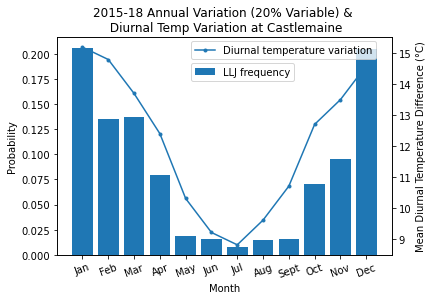

In [30]:
ESTdelta = timedelta(hours=9) #in september 0000UTC = 0900EST - use ptyz for dealing with daylight saving
t = np.arange(dstart + ESTdelta, dstart + timedelta(hours=nt+9), timedelta(hours=1)).astype(datetime) 
jetbinary_variable['time'] = t
frequency = jetbinary_variable.groupby('time.month').sum()
monthly_frequency = np.empty(12)
months = np.arange(0,12)
month_string = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
for t in months:
    monthly_frequency[t] = (frequency[t,...].sum())/(jetbinary_variable.sum()) 
    
# Overlay Castelmaine Climate Stats
max_temp = np.array([28.4,28.3,24.7,20.1,15.7,12.7,11.8,13.2,15.8,19.4,22.8,25.6])
min_temp = np.array([13.2,13.5,11.0,7.7,5.4,3.5,3.0,3.6,5.1,6.7,9.3,11.0])

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(months,monthly_frequency, label = 'LLJ frequency')
ax2.plot(max_temp-min_temp, marker = '.', label = 'Diurnal temperature variation')
ax1.set_ylabel('Probability') 
ax1.set_xlabel('Month')
ax1.set_title('2015-18 Annual Variation (20% Variable) & \n Diurnal Temp Variation at Castlemaine')
ax1.set_xticks(ticks = months, labels = month_string, rotation = 20)
ax2.set_ylabel('Mean Diurnal Temperature Difference (\N{DEGREE SIGN}C)')
ax1.legend(loc =[0.4,0.8])
ax2.legend(loc =[0.4,0.9])
plt.savefig('Annual LLJs with diurnal variation ')


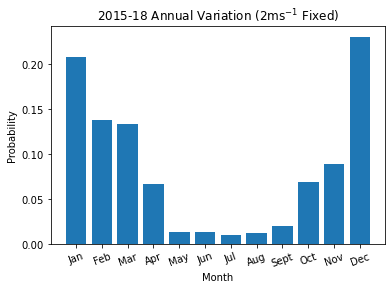

In [31]:
annual_hist(jetbinary_fixed, '2015-18 Annual Variation (2$\mathregular{ms^{-1}}$ Fixed)')
# annual_hist(jetbinary_variable.isel(latitude = slice(3,9), longitude= slice(24,30)), 'Annual Variation Mt Mercer (20% Variable)')
# plt.show()
# annual_hist(jetbinary_fixed.isel(latitude = slice(3,9), longitude= slice(24,30)), 'Annual Variation Mt Mercer (2$\mathregular{ms^{-1}}$ Fixed)')
# plt.show()

In [22]:
jetbinary_variable = (speed_crit & below_crit & above_crit)
t = np.arange(dstart + solartime, dstart + timedelta(hours=nt)+solartime, timedelta(hours=1)).astype(datetime) 
jetbinary_variable['time'], profmax_ind['time'] = t,t
heights_std = np.arange(200,1100,100)
jet_ind = profmax_ind.where(jetbinary_variable) # Jet index heights filtered for where a LLJ exists
seasonal_frequency = np.zeros([9,4])
frequency = np.zeros(9)
for t,i in enumerate(np.arange(1,10)): # Index level 1 to 10
    frequency[t] = np.count_nonzero(jet_ind == i) # Count number of jets at each index level (height)
    seasonal_frequency[t,:] = jet_ind.where( # Count number of jets at each index level by season
        jet_ind == i).groupby('time.season').sum(dim = ['time']).sum(dim = ['latitude', 'longitude'])

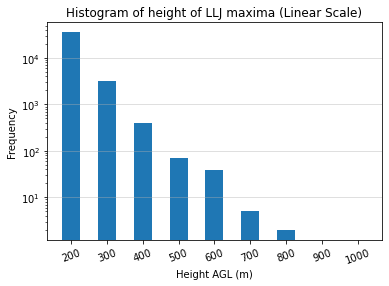

In [26]:
plt.bar(heights_std, frequency, width = 50)
plt.ylabel('Frequency') 
plt.xlabel('Height AGL (m)')
plt.title('Histogram of height of LLJ maxima (Linear Scale)')
plt.xticks(ticks = heights_std, labels = heights_std, rotation = 20)
plt.yscale('log')
plt.grid(axis = 'y', alpha = 0.5)
plt.savefig('Height of maximum wind speed for LLJ occurences (Linear Scale)')

In [24]:
(frequency[0]/frequency.sum())*100

90.49567072405573

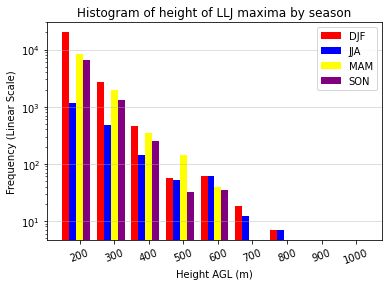

In [27]:
month_string = ['DJF','JJA','MAM','SON']
colours = ['red','blue','yellow', 'purple']
width = 20
for i in range(0,4):
    plt.bar(heights_std+(width*(i-2)), seasonal_frequency[:,i], width = width, color = colours[i], label = month_string[i])

plt.ylabel('Frequency (Linear Scale)') 
plt.xlabel('Height AGL (m)')
plt.title('Histogram of height of LLJ maxima by season')
plt.xticks(ticks = heights_std, labels = heights_std, rotation = 20)
plt.yscale('log')
plt.grid(axis = 'y', alpha = 0.5)
plt.legend()
plt.savefig('Histogram of LLJ maxima by season (Linear scale)')

#### Data Slicing:

In [ ]:
# dstart = '2015-01-01'
# dend = '2018-12-31'
# ndays = 365*3+366
# jetbinary_variable = jetbinary_variable.sel(time = slice(dstart, dend))
# wsprof_interp = wsprof_interp.sel(time = slice(dstart, dend))
# totaljets_variable = jetbinary_variable.sum(dim = 'time')

In [24]:
# 6am (including) to 5pm
daytime = jetbinary_variable[(jetbinary_variable.time.dt.hour>=6)&(jetbinary_variable.time.dt.hour<18)]

# NOT daytime, therefore 6pm (including) to 5am
nighttime = jetbinary_variable[~((jetbinary_variable.time.dt.hour>=6)&(jetbinary_variable.time.dt.hour<18))]

totaljets_night = nighttime.sum(dim='time')
print('Total jets during daytime', daytime.sum())
print('Total jets during nighttime', nighttime.sum())
print((nighttime.sum()/(daytime.sum()+nighttime.sum()))*100, '% of jets occur at night')

Total jets during daytime <xarray.DataArray 'wsprof_interp' ()>
array(454416)
Total jets during nighttime <xarray.DataArray 'wsprof_interp' ()>
array(2627680)
<xarray.DataArray 'wsprof_interp' ()>
array(85.25626716) % of jets occur at night


In [25]:
# How many nights contain at least one jet?
nighttime1 = nighttime*1
nighttime1 = nighttime.sel(time=slice(datetime(2017,12,31,6,0,0),datetime(2018,12,31,6,0,0)))
jethours_sum = nighttime1.sum(dim = ['latitude', 'longitude'])
nonzerohour_sum = np.count_nonzero(jethours_sum)
print('Proportion of nighttime hours with at least one jet occurence:', np.round((nonzerohour_sum/len(nighttime1))*100,4), '%')

Proportion of nighttime hours with at least one jet occurence: 91.5753 %


In [26]:
ndays = 365
jetnight1 = np.empty(ndays) # Empty variable of number of days in 4 years
jetnight3 = np.empty(ndays) 
for i in range(0,ndays):
    onenight = np.empty(12) # Empty variable resets each day
    istart = i*12 # Iterates first 12 hours, second 12 hours, third etc...
    iend = (i*12)+12
    for index, j in enumerate(range(istart,iend)): # 12 hours per night
        onenight[index] = jethours_sum[j] # Sums total jets during each 12 hour period
    if onenight.sum()>0: # If the sum of total jets during the 12 hour period > 0, the night is a jet night
        jetnight1[i] = 1
    else:
        jetnight1[i] = 0
    if onenight.sum()>3: # If sum of jets > 3
        jetnight3[i] = 1
    else:
        jetnight3[i] = 0
        
jetnights1_proportion = jetnight1.sum()/len(jetnight1)
jetnights3_proportion = jetnight3.sum()/len(jetnight3)
print('Percentage of nights with at least one jet occurence: ', jetnights1_proportion*100, '%')
print('Percentage of nights with at least three jet occurences: ', jetnights3_proportion*100, '%')

Percentage of nights with at least one jet occurence:  98.63013698630137 %
Percentage of nights with at least three jet occurences:  98.08219178082192 %


### Classify and find jetnights

In [27]:
ws100m = wsprof_interp[:,0,...]
ws100m_night = ws100m[~((ws100m.time.dt.hour>=6)&(ws100m.time.dt.hour<18))]
ws100m_night = ws100m_night.sel(time = slice(datetime(2017,12,31,6,0,0),datetime(2018,12,31,6,0,0)))

In [28]:
#len(ws100m1D) == ndays*ni*nj*12

In [29]:
nighttime1_n = nighttime1.to_numpy()
# nighttime1 = xarray.DataArray(nighttime1_reshaped, dims=("day","hour", "latitude","longitude"))  
nighttime1_reshaped = nighttime1_n.reshape(-1,1)
#nighttime1_reshaped = nighttime1_reshaped.ravel()

In [1]:
# def consecutive(l): #Function from https://www.codegrepper.com/code-examples/python/count+consecutive+values+in+python
#     return [sum(g) for i, g in groupby(l) if i == 1] 

# jetnight2 = np.empty([ndays,nj,ni]) # Empty variable for # days and # gridpoints
# ws100m_jn = np.empty([ndays,nj,ni])
# ws100m_nonjn = np.empty([ndays,nj,ni])
     
# for i in range(0,ni):
#     for j in range(0,nj):
#         for d in range(0,ndays):
#             onenight = np.empty(12) # Empty variable resets each day
#             ws100m_1n = np.empty(12)
#             dstart = d*12 # Iterates first 12 hours, second 12 hours, third etc...
#             dend = (d*12)+12
#             for index, h in enumerate(range(dstart,dend)): # 12 hours per night
#                 onenight[index] = nighttime1_n[h,j,i] # Creates array of one night (12 hours)
#                 ws100m_1n[index] = ws100m_night[h,j,i]
#                 if len(consecutive(onenight))==0: # len prevents error occuring from empty sequence when no consecutive jets exist
#                     jetnight2[d,j,i] = 0
#                 elif max(consecutive(onenight))>=2: # If max consecutive jets >=2, it is a jet night
#                     jetnight2[d,j,i] = 1
#                 else:
#                     jetnight2[d,j,i] = 0

#                 if jetnight2[d,j,i] == 1:
#                     ws100m_jn[d,j,i] = ws100m_1n.mean() # Mean 100m windspeed on jetnight
#                     ws100m_nonjn[d,j,i] = np.nan

#                 elif jetnight2[d,j,i] == 0:
#                     ws100m_jn[d,j,i] = np.nan
#                     ws100m_nonjn[d,j,i] = ws100m_1n.mean() # Mean 100m windspeed on non-jetnight

# jetnight2_sum = jetnight2.sum(axis=0) # Sums over time axis (# of days)
# jetnights2 = jetnight2_sum.sum()/len(jetnight2.reshape(-1,1))
# print("Percentage of nights classified as 'jetnights'", jetnights2*100, '%' )

In [24]:
len(nighttime1_n)

4380

In [32]:
ndays = 365
jetnight2 = np.empty([ndays,nj,ni]) # Empty variable for # days and # gridpoints
ws100m_jn = np.empty([ndays,nj,ni])
ws100m_nonjn = np.empty([ndays,nj,ni])
     
for i in range(0,ni):
    for j in range(0,nj):
        for d in range(0,ndays):
            onenight = np.empty(12) # Empty variable resets each day
            ws100m_1n = np.empty(12)
            dstart = d*12 # Iterates first 12 hours, second 12 hours, third etc...
            dend = (d*12)+12
            for index, h in enumerate(range(dstart,dend)): # 12 hours per night
                onenight[index] = nighttime1_n[h,j,i] # Creates array of one night (12 hours) for nighttime jets
                ws100m_1n[index] = ws100m_night[h,j,i]
                if onenight.sum() >= 2: # sum of jet hours within one night >= 2
                    jetnight2[d,j,i] = 1
                else:
                    jetnight2[d,j,i] = 0

                if jetnight2[d,j,i] == 1:
                    ws100m_jn[d,j,i] = ws100m_1n.mean() # Mean 100m windspeed on jetnight
                    ws100m_nonjn[d,j,i] = np.nan

                elif jetnight2[d,j,i] == 0:
                    ws100m_jn[d,j,i] = np.nan
                    ws100m_nonjn[d,j,i] = ws100m_1n.mean() # Mean 100m windspeed on non-jetnight

jetnight2_sum = jetnight2.sum(axis=0) # Sums over time axis (# of days)
jetnights2 = jetnight2_sum.sum()/len(jetnight2.reshape(-1,1))
print("Percentage of nights classified as 'jetnights'", jetnights2*100, '%' )

Percentage of nights classified as 'jetnights' 12.902211586070308 %


In [43]:
print('Total number of jetnights:', jetnight2_sum.sum())
print('Mean 100m windspeed on jetnight:', ws100m_jn.mean(skipna = True)) # Overall mean of the mean 100m ws on jetnights
print('Mean 100m windspeed on non-jetnight:', ws100m_nonjn.mean(skipna = True))

Total number of jetnights: 3138.0


TypeError: _mean() got an unexpected keyword argument 'skipna'

In [49]:
jetnight_binary = jetnight2_sum

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


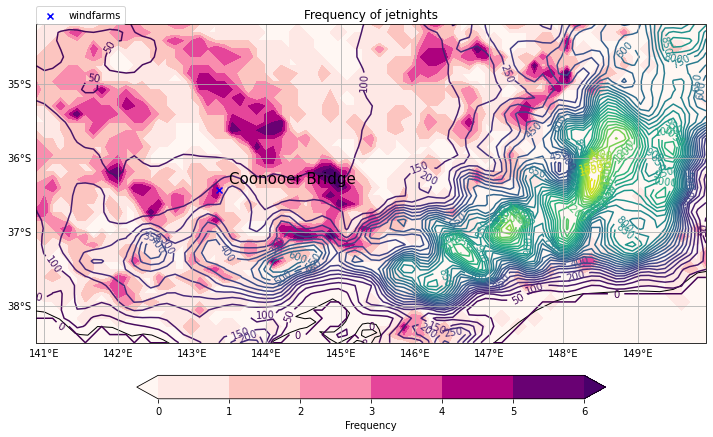

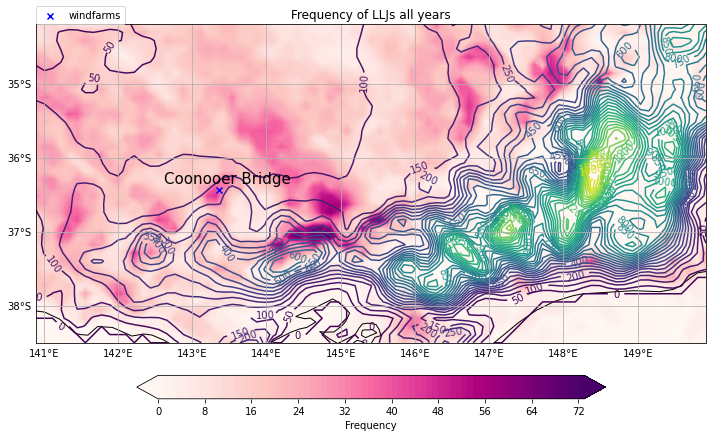

In [50]:
plt.figure(figsize = (12,12))
contourplot(jetnight_binary, 'Frequency of jetnights')
plt.savefig('Frequency of jetnights all years')

plt.figure(figsize = (12,12))
contourplot(totaljets_night, 'Frequency of LLJs all years')
plt.savefig('Frequency of LLJs all years')

### Calculate average 100m windspeed on 'jetnights'

In [ ]:
ws100m = wsprof_interp[:,0,...]
ws100m1D = ws100m.stack(single_dim = ("time","latitude", "longitude"))

In [33]:
# lon2d = xarray.DataArray(lon2d, name = 'lon2d')
# lat2d = xarray.DataArray(lat2d, name = 'lat2d')
# wsprof_interp = xarray.DataArray(wsprof_interp, name = 'wsprof_interp')
# profmax_ind = xarray.DataArray(profmax_ind, name = 'profmax_ind')
# wsabove = xarray.DataArray(wsabove, name = 'wsabove')
# profmax = xarray.DataArray(profmax, name = 'profmax')
# wsbelow = xarray.DataArray(wsbelow, name = 'wsbelow')
jetnight2 = xarray.DataArray(jetnight2, name = 'jetnight2_v4')
ws100m_jn = xarray.DataArray(ws100m_jn, name = 'ws100m_jnv4')
ws100m_nonjn = xarray.DataArray(ws100m_nonjn, name = 'ws100m_nonjnv4')
data = xarray.merge([jetnight2, ws100m_jn, ws100m_nonjn], compat = 'override')

# data = xarray.merge([lon2d, lat2d, wsprof_interp, profmax_ind, wsabove, profmax, wsbelow], compat = 'override')
# data.to_netcdf('/g/data/v46/lh2344/LLJ_2015_18(1).nc')
# data1 = xarray.merge([data, ws100m1D], compat = 'override')
# data1.to_netcdf('/g/data/v46/lh2344/LLJ_2015_18.nc')
data.to_netcdf('/g/data/v46/lh2344/jetnightsv4')

In [ ]:
plt.figure(figsize = (12,12))
contourplot(jetnight_sum, 'Frequency of jetnights')
plt.savefig('Frequency of jetnights all years')

plt.figure(figsize = (12,12))
contourplot(totaljets_variable, 'Frequency of all jets')


### Mask topography <1200m

In [ ]:
topog1200 = topog>1200
mask = jetbinary_variable[0,...].where(topog1200)
topog1200